<a href="https://colab.research.google.com/github/teiabessa/dio-lab-open-source/blob/main/Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 60kB/s 
     |████████████████████████████████| 3.1MB 38.6MB/s 
     |████████████████████████████████| 501kB 47.8MB/s 


In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns

import pandas as pd

In [ ]:
tf.__version__

'2.0.0-beta1'

In [ ]:
%load_ext tensorboard

In [ ]:
logdir='log'

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes=[0,1,2,3,4,5,6,7,8,9]

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
            y=train_labels,
            epochs=5,
            validation_data=(test_images, test_labels))

W0628 03:40:57.820147 140198879729536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.1430 - accuracy: 0.9563 - val_loss: 0.0452 - val_accuracy: 0.9854
Epoch 2/5
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0335 - val_accuracy: 0.9893
Epoch 3/5
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.0327 - accuracy: 0.9900 - val_loss: 0.0369 - val_accuracy: 0.9885
Epoch 4/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.0335 - val_accuracy: 0.9899
Epoch 5/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0337 - val_accuracy: 0.9892


In [ ]:
y_true=test_labels
y_pred=model.predict_classes(test_images)


In [ ]:
classes=[0,1,2,3,4,5,6,7,8,9]

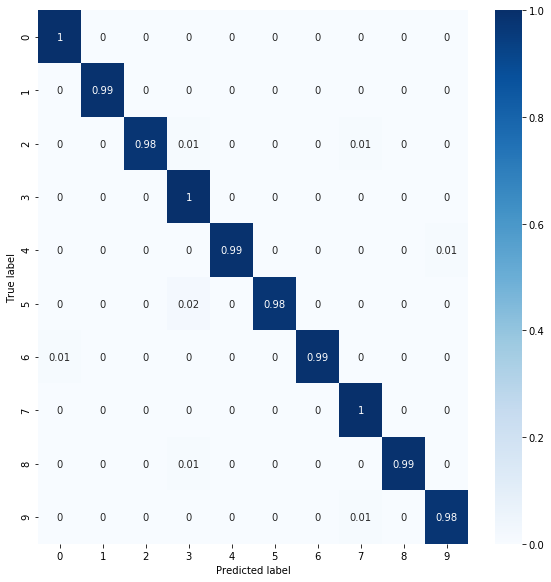

In [ ]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred = model1.predict_classes(test_images)

  con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=test_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)

  image = tf.expand_dims(image, 0)

  # Log the confusion matrix as an image summary.
  with file_writer.as_default():
    tf.summary.image("Confusion Matrix", image, step=epoch)


logdir='logs/images'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
model1.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0,
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)

In [ ]:
# Start TensorBoard.
%tensorboard --logdir logs/images